This notebook will explore data gathered from the US Airlines Sentiment Data Set

Summary of Data: Twitter responses towards US Airlines and the emotional state of each party.

Data Information:
Length of data set: 14,640
Columns in the data set:'tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'


In [1]:
# Importing Python modules
import numpy as np
import pandas as pd
import os

In [2]:
# Importing the dataset with pandas

# Changing the working directory to the raw data directory
os.chdir('/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/data/raw/US_Airline_Sentiment')
data_temp = pd.read_csv('Tweets.csv')

In [3]:
data_temp.columns, data_temp.shape

(Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
        'negativereason', 'negativereason_confidence', 'airline',
        'airline_sentiment_gold', 'name', 'negativereason_gold',
        'retweet_count', 'text', 'tweet_coord', 'tweet_created',
        'tweet_location', 'user_timezone'],
       dtype='object'), (14640, 15))

In [4]:
# Minimalist appraoch to labelling the above data set: 
# Create a binary classification scheme = the headline has a "+" or "-" emotional response.
## Only collect the responses that gave a positive or negative emotional response from the airline

# data_pn = data_temp[data_temp.airline_sentiment != 'neutral'] 
# data_pn.airline_sentiment.unique(), data_pn.shape  

# Droping labels with nan and converting them
#data_temp.negativereason_confidence.dropna(how='all',inplace=True)
#data_temp['negativereason_confidence'] = data_temp.negativereason_confidence.round(0).astype(int)
#data_temp.negativereason_confidence.dropna(how='all',inplace=True)
#data_temp.negativereason_confidence.unique()


# # Gathering the text and labels

text = data_temp.text.copy(deep=True)
labels_confvalues = data_temp.negativereason_confidence
labels_confvalues.unique()
# # Pre-processing labels. Removing "inf" and nan
labels_confvalues.replace([np.inf, -np.inf], np.nan)
labels_confvalues.dropna()

# # Seperating the labels by seperating the confidence labels to be:
# # negative > 0.5, positive is <= 0.5
labels_confvalues.dropna(how='all', inplace=True)
labels = labels_confvalues.round(0).astype(int)
filter_text = labels.index
text = text[filter_text]

# Printing the number of each class:
print("The total number of tweets are:", labels.shape[0])
print("The number (out of 5000) of negative emotional headlines =", labels.shape[0] - labels.sum())
print("The number (out of 5000) of positive emotional headlines =", labels.sum())
print("The niave classification (1 class fit to all) is =", 1-2111.0/7397)

The total number of tweets are: 10522
The number (out of 5000) of negative emotional headlines = 3125
The number (out of 5000) of positive emotional headlines = 7397
The niave classification (1 class fit to all) is = 0.7146140327159659


In [5]:
# Forcing a balance dataset -- NIAVELY REMOVING POSITIVE TWEETS To BALANCE THE DATASET

## Splitting the Data into a Training, Validation, and Test Set
## Fractions are: Training = 80%, Validation = 10%, Test = 10 %

from sklearn.model_selection import train_test_split  


## For the time being, the following code forces the training, validation, and test data sets are balanced
num_pos_labels = labels.sum() # 1418 headlines
num_neg_labels = labels.shape[0] - num_pos_labels # 3582 headlines
num_pos_labels_2drop = num_pos_labels - num_neg_labels # 2164 headlines
print(num_pos_labels)
print(num_neg_labels)
print(num_pos_labels_2drop)
# cnt = 0

index_pos = labels[labels == 1].index
index_neg = labels[labels == 0].index
labels_temp_bal_pos = labels[index_pos[num_pos_labels_2drop:]]
labels_temp_bal_neg = labels[index_neg]

labels_temp_bal = labels_temp_bal_neg.combine(labels_temp_bal_pos, max, fill_value=0)

print("The total length of the label series = ", labels_temp_bal.shape)
print("The total number of positive labels =",labels_temp_bal.sum())
labels_temp_bal.loc[14638], labels.loc[14638]

## Ensuring we use the appropriate text from the balanced labeled series
labels_temp_bal_indices = labels_temp_bal.index
text_bal = text[labels_temp_bal_indices]

# cnt = 0
# for i in range(labels_temp_bal.shape[0]):
#     if labels_temp_bal.iloc[i] == 1 and cnt < (num_pos_labels_2drop+1):
#         labels_temp_bal[i].drop(inplace=True)
#         cnt += 1

# index_Label0 = data_temp_bal.index[data_temp_bal['BinaryEmoLabel'] == 0].tolist()


# Labels = data_temp.BinaryEmoLabel
# X_train, X_test, y_train, y_test = train_test_split(data_temp, Labels, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)

7397
3125
4272
The total length of the label series =  (6250,)
The total number of positive labels = 3125


## Pre-processing the text / headlines
#### Initially the steps which follow were inspired by the Medium Blog Posts:
#### https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184
#### https://towardsdatascience.com/sentiment-analysis-with-python-part-2-4f71e7bde59a
#### Written By: Aaron Kub

#### https://towardsdatascience.com/twitter-sentiment-analysis-classification-using-nltk-python-fa912578614c
#### Written By: Mohamed Afham ** Follwoing this scheme to begin the process

In [6]:
#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [7]:
## Combining all the above text pre-processing into one function 

def text_processing(headline):
    
    #Generating the list of words in the headline (hastags and other punctuations removed)
    def form_sentence(headline):
        headline_blob = TextBlob(headline)
        return ' '.join(headline_blob.words)
    new_headline = form_sentence(headline)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(headline):
        headline_list = [ele for ele in headline.split() if ele != 'user']
        clean_tokens = [t for t in headline_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess
    no_punc_headline = no_user_alpha(new_headline)
    
    #Normalizing the words in headlines 
    def normalization(headline_list):
        lem = WordNetLemmatizer()
        normalized_headline = []
        for word in headline_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_headline.append(normalized_text)
        return normalized_headline
    
    
    return normalization(no_punc_headline)

In [8]:
def Int2EmotionConverter(IntEmo):
    """
    Converts the integer value of the emotion predicted to the emotions word in English
    """
    EmoWords = pd.DataFrame(['Sad','Happy'])
    return EmoWords.iloc[IntEmo][0]

In [9]:
# scikit-learn: Pre-defining a workflow of algorithm (Niave-Bayse Classifier)
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [41]:
### Trainiing Model ####
msg_train, msg_test, label_train, label_test = train_test_split(text_bal, labels_temp_bal, test_size=0.1)
pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))
# What would the accuracy of the Training Data Set is we niavely set all labels to 0
print("The accuracy of labelling all headlines NEGATIVE is:",1-label_train.sum()/len(label_train))

print("This model's accuracy is better than the Niave assumption by:", accuracy_score(predictions,label_test) - 1+label_train.sum()/len(label_train)) 

              precision    recall  f1-score   support

           0       0.72      0.84      0.78       272
           1       0.86      0.75      0.80       353

    accuracy                           0.79       625
   macro avg       0.79      0.79      0.79       625
weighted avg       0.80      0.79      0.79       625

[[229  43]
 [ 89 264]]
0.7888
The accuracy of labelling all headlines NEGATIVE is: 0.49902222222222226
This model's accuracy is better than the Niave assumption by: 0.2897777777777777


In [11]:
### Now predict the emotional label of a senetence chosen by the user
text.iloc[0]

"@VirginAmerica plus you've added commercials to the experience... tacky."

In [12]:
dummy_index = 90

temp_text = pd.Series([])
temp_text[0] = text.iloc[dummy_index]
type(temp_text)

out_temp = pipeline.predict(temp_text)
print("The sentence input was:\n",temp_text[0])
print("The emotional prediction was:", Int2EmotionConverter(out_temp[0]))

The sentence input was:
 @VirginAmerica I'd love to know what your policy is for damaged luggage.
The emotional prediction was: Sad


In [13]:
## Randomly print a positive review and a negative review -- MANUAL INSPECTION OF RESULTS

# Collecting all preditions
all_preds = pipeline.predict(text)

In [14]:
# Gathering all indices for "positive" and "negative" reviews
pred_neg_indices = np.where(all_preds == 0)[0] # all_preds[all_preds == 0].index 
pred_pos_indices = np.where(all_preds == 1)[0] # all_preds[all_preds == 1].index

neg_index_ran = np.random.choice(pred_neg_indices,1)[0]
pos_index_ran = np.random.choice(pred_pos_indices,1)[0]
#print(neg_index_ran)
#print(pos_index_ran)

print("THIS IS THE SAD CASE!!")
# Printing the results of the negative text
print("The sentence input was:\n",text.iloc[neg_index_ran])
print("The emotional prediction was:", Int2EmotionConverter(all_preds[neg_index_ran]))
print("________________________")
print("THIS IS THE HAPPY CASE!!")
# Printing the results of the positive text
print("The sentence input was:\n",text.iloc[pos_index_ran])
print("The emotional prediction was:", Int2EmotionConverter(all_preds[pos_index_ran]))

THIS IS THE SAD CASE!!
The sentence input was:
 @SouthwestAir @BrittanyOBX11, keeping families apart w/ your quirky, archaic policies. Any other airline accommodates in this situation.
The emotional prediction was: Sad
________________________
THIS IS THE HAPPY CASE!!
The sentence input was:
 @USAirways can you please help me find my luggage since you're the one who lost it? Your customer service SUCKS.
The emotional prediction was: Happy


## Now predicting the emotional sentiment (neg., pos.) given a user string

In [17]:
temp_text = pd.Series([])
temp_text[0] = "I feel great, thank you!"

out_temp = pipeline.predict(temp_text)
print("The sentence input was:\n",temp_text[0])
print("The emotional prediction was:", Int2EmotionConverter(out_temp[0]))

The sentence input was:
 I feel great, thank you!
The emotional prediction was: Sad


In [ ]:
temp_text
out_temp[0]
Int2EmotionConverter(out_temp[0])

## REAL CONVERSATION EXAMPLE CASE ##

In [43]:
# importing the real conversation
os.chdir('/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/data/raw')
real_conv = pd.read_csv('real_chat.txt',sep="\n", header=None, dtype=str) 
real_conv = real_conv[0] # converts the DataFrame to a DataSeries 
                         # as desired for the label predictions


# Generating the emotional predictions from the above text
emos_real_chat = pipeline.predict(real_conv)

# generating the speaker/writer
speaker = pd.Series([])
for i in range(real_conv.shape[0]):
    speaker[i] = real_conv.iloc[i].split()[0][:-1] 

speaker.unique()

array(['Customer', 'CS_Agent'], dtype=object)

[]

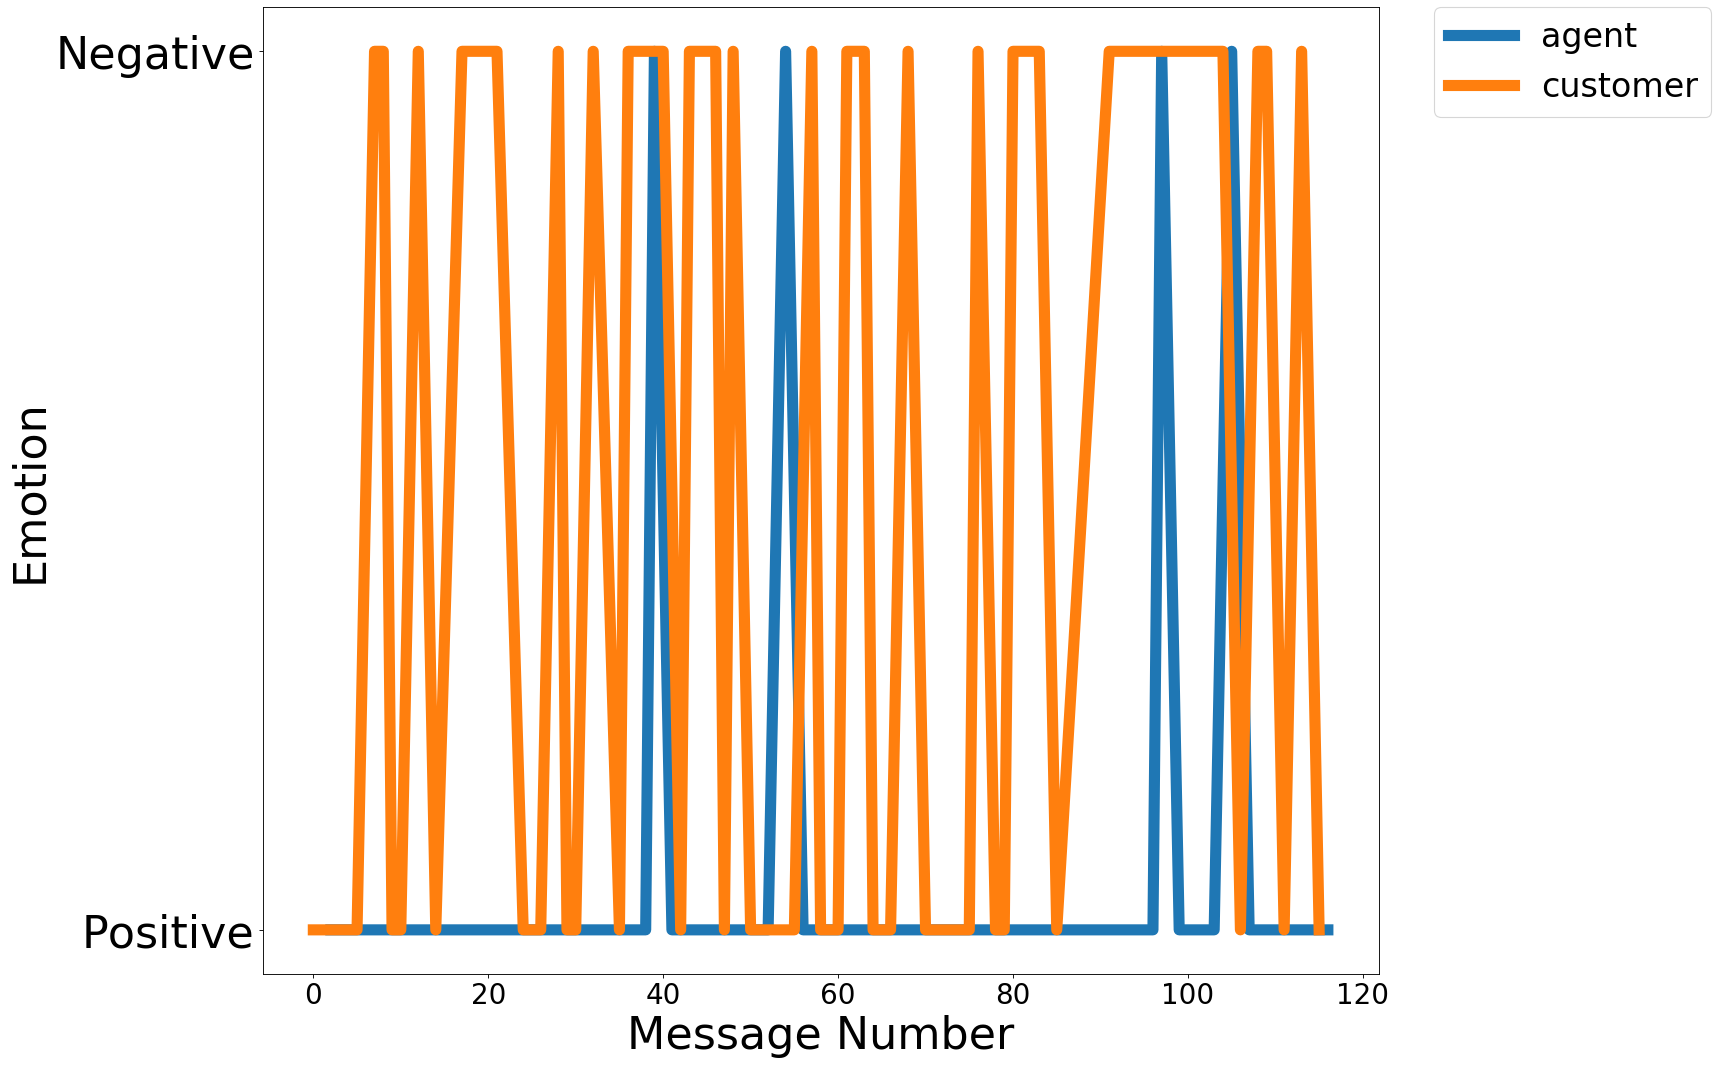

In [52]:
type(speaker), type(emos_real_chat)
chat_df = pd.DataFrame([])
chat_df['speaker'] = speaker
chat_df['emotions'] = emos_real_chat
index_agent = chat_df.index[chat_df['speaker'] == 'CS_Agent' ].tolist()
index_customer = chat_df.index[chat_df['speaker'] == 'Customer' ].tolist()


# fig, ax = plt.subplots()
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(index_agent,chat_df['emotions'][index_agent],label='agent',lw=10)
plt.plot(index_customer,chat_df['emotions'][index_customer],label='customer', lw=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,prop={'size': 30} )
plt.xlabel('Message Number', size=40)
plt.ylabel('Emotion',size=40)
plt.xticks(fontsize=25)
plt.yticks([0,1],labels=['Positive','Negative'],fontsize=40)

# Changing the y-labels to "Sad" (0) and "Happy" (1)
# labels = [item.get_text() for item in ax.get_yticklabels()]
# labels[0] = 'Sad'
# labels[1] = 'Happy'

plt.savefig("Preliminary_AgentCustomer_Emotional_Output.png", bbox_inches='tight', dpi=100)
plt.plot()
#final_df.plot(x='index',y='emotions')


In [40]:
os.getcwd()

'/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/data/raw'

In [ ]:
# generating the plot to show the emotional state of each user in a given text
import matplotlib.pyplot as plt

x_ticks = np.arange(1,len(emos_real_chat))
print(x_ticks)
plt.xlabel('Sequential Text Message Number', size=20)
plt.ylabel('Speaker', size=20)
plt.plot(emos_real_chat,speaker)


# Customer Support on Twitter

In [ ]:
## Importing the "Customer Support on Twitter"
os.chdir('/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/data/raw/CustomerSupportTwitter')
cst_orig = pd.read_csv('twcs.csv')
print(cst_orig.shape)
cst_orig.dropna(inplace=True) # removing the NaN valued rows as they add to noise
print(cst_orig.shape)

In [ ]:
cst_orig.columns, cst_orig.shape

In [ ]:
## identifying conversations -- gathering the unqiue pairs of tweets
tweetID_pairs = pd.DataFrame([])
tweetID_pairs['author_id'] = cst_orig['author_id']
tweetID_pairs['response_tweet_id'] = cst_orig['response_tweet_id']
print("The length of original tweet id-pair dataframe is:", tweetID_pairs.shape[0])

# Removing the NaN values
tweetID_pairs.dropna(inplace=True)
print("The Length after the NaN values are dropped", tweetID_pairs.shape[0])

# Generate a numpy array to sort the rows
tweetID_pairs_np = tweetID_pairs.to_numpy(copy=True)
tweetID_pairs_np = np.sort(tweetID_pairs_np)

tweetID_pairsSrtd = pd.DataFrame([])
tweetID_pairsSrtd['ID1'] = tweetID_pairs_np[:,0]
tweetID_pairsSrtd['ID2'] = tweetID_pairs_np[:,1]
tweetID_pairsSrtd.drop_duplicates(inplace=True)
print("The length of the unique tweet pair", tweetID_pairsSrtd.shape[0])

In [ ]:
tweetID_pairsSrtd['ID1'].unique().shape, tweetID_pairsSrtd['ID2'].unique().shape

In [ ]:
## Connecting twiter conversations together through 'tweet_id', 'response_tweet_id', 'in_response_to_tweet_id'
convos = pd.DataFrame([])

for i in range(cst_orig.shape[0]):
    convos["BaseID"].iloc[i] = cst_orig['tweet_id']
    response_temp = cst_orig['response_tweet_id']
    resp_list = 

## -----------------------The Test Dev. Case is Completed ---------------------------------

# ------------------------------------------------------------------------------------

# APPENDIX: The Individual Functions and Examples cases to showcase how they work


In [ ]:
## Punctuation Removal
def form_sentence(headline):
    headline_blob = TextBlob(headline)
    return ' '.join(headline_blob.words)

data_temp['HL_PuncRem_1'] = 'NaN'
for i in range(data_temp.shape[0]):
    data_temp.HL_PuncRem_1.iloc[i] = form_sentence(data_temp['headline'].iloc[i])
    
    

In [ ]:
## Removing Stop-Words (e.g: is, are, have)
def no_user_alpha(headline):
    headline_list = [ele for ele in headline.split() if ele != 'user']
    clean_tokens = [t for t in headline_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess

data_temp['HL_StopWords_2'] = 'NaN'
for i in range(data_temp.shape[0]):
    data_temp.HL_StopWords_2.iloc[i] = no_user_alpha(data_temp['HL_PuncRem_1'].iloc[i])


In [ ]:
print(data_temp.HL_StopWords_2.iloc[0])
print(data_temp.headline.iloc[0])

In [ ]:
# Normalize Text -- NLTK’s built-in WordNetLemmatizer does this 
def normalization(headline_list):
        lem = WordNetLemmatizer()
        normalized_headline = []
        for word in headline_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_headline.append(normalized_text)
        return normalized_headline
    
data_temp['HL_Normalize_3'] = 'NaN'
for i in range(data_temp.shape[0]):
    data_temp.HL_Normalize_3.iloc[i] = normalization(data_temp['HL_StopWords_2'].iloc[i])
    

In [ ]:
print(data_temp.HL_Normalize_3.iloc[0])
print(data_temp.headline.iloc[0])